In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from rdkit.Chem import rdFingerprintGenerator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qiskit.quantum_info as qi
import scienceplots
from qiskit.circuit.library import UnitaryOverlap
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

plt.style.use(['science', 'ieee', 'no-latex'])

In [16]:
def coulomb_matrix(smiles: str, add_hydrogens: bool = False, bond_coupling: float = 1.0) -> np.ndarray:
    """
    Computes the adjacent Coulomb matrix for a given molecule specified by a SMILES string,
    using specific average bond lengths for adjacent atom pairs.
    
    Parameters:
    - smiles (str): The SMILES string representing the molecule.
    - add_hydrogens (bool): Whether to add hydrogen atoms to the molecule.
    
    Returns:
    - np.ndarray: The Coulomb matrix of the molecule.
    """
    # Load the molecule from the SMILES string
    molecule = Chem.MolFromSmiles(smiles)
    
    # Add hydrogen atoms if specified
    if add_hydrogens == True:
        molecule = Chem.AddHs(molecule)
    
    # Get the atomic numbers of the atoms
    atomic_numbers = [atom.GetAtomicNum() for atom in molecule.GetAtoms()]
    
    # Number of atoms
    num_atoms = len(atomic_numbers)
    
    # Initialize the Coulomb matrix
    coulomb_matrix = np.zeros((num_atoms, num_atoms))
    
    # Fill in the Coulomb matrix
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                # Diagonal elements: 0.5 * Z_i^2.4
                coulomb_matrix[i, j] = (0.5 * atomic_numbers[i] ** 2.4) 
                # coulomb_matrix[i, j] = (atomic_numbers[i]) 
            else:
                # Find the bond between atoms i and j
                bond = molecule.GetBondBetweenAtoms(i, j)
                if bond:
                    bond_type = bond.GetBondType()
                    if bond_type == Chem.rdchem.BondType.SINGLE:
                        distance = 1
                    elif bond_type == Chem.rdchem.BondType.DOUBLE:
                        distance = 2
                    elif bond_type == Chem.rdchem.BondType.TRIPLE:
                        distance = 3
                    elif bond_type == Chem.rdchem.BondType.AROMATIC:
                        distance = 1.5
                    coulomb_matrix[i, j] = (atomic_numbers[i] * atomic_numbers[j] / distance) * bond_coupling
    
    return coulomb_matrix

In [3]:
def matrix_to_circuit(matrix, num_qubits, n_layers: int = 1, reverse_bits: bool = False, initial_layer: str = 'rx', entangling_layer: str = 'rzz', n_atom_to_qubit: int = 1, interleaved: str = None) -> QuantumCircuit:
    """
    Converts a matrix to a QuantumCircuit object.
    
    Parameters:
    - matrix (np.ndarray): The matrix to convert.
    
    Returns:
    - QuantumCircuit: The QuantumCircuit object representing the matrix.
    """
    # Get the number of qubits required to represent the matrix
    matrix_size = matrix.shape[0]

    # Toggle reverse bits
    if reverse_bits == True:
        m = np.flip(np.arange(num_qubits - matrix_size * n_atom_to_qubit, num_qubits))
    else:
        m = np.arange(0, matrix_size * n_atom_to_qubit)
    
    m = np.reshape(m, (matrix_size, n_atom_to_qubit))
    
    # Initialize the QuantumCircuit object
    qc = QuantumCircuit(num_qubits)
    for _ in range(n_layers):
        for i in range(matrix_size):
            if initial_layer == 'ry':
                for k in range(n_atom_to_qubit):
                    qc.ry(matrix[i, i], m[i,k])
            elif initial_layer == 'rz':
                for k in range(n_atom_to_qubit):
                    qc.rz(matrix[i, i], m[i,k])
            else:
                for k in range(n_atom_to_qubit):
                    qc.rx(matrix[i, i], m[i,k])
        if interleaved == 'cnot' or interleaved == 'cx':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.cx(a[j], a[j + 1])
        elif interleaved == 'cz':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.cz(a[j], a[j + 1])
        elif interleaved == 'rxx':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.rxx(matrix[i, i], a[j], a[j + 1])
        elif interleaved == 'ryy':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.ryy(matrix[i, i], a[j], a[j + 1])
        elif interleaved == 'rzz':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.rzz(matrix[i, i], a[j], a[j + 1])
        for i in range(matrix_size):
            for j in range(matrix_size):
                if (i < j) and (matrix[i, j] != 0.0):
                    if n_atom_to_qubit == 1:
                        q_c = m[i]
                        q_t = m[j]
                        if entangling_layer == 'rxx':
                            qc.rxx(matrix[i, j], q_c, q_t)
                        elif entangling_layer == 'ryy':
                            qc.ryy(matrix[i, j], q_c, q_t)
                        else:
                            qc.rzz(matrix[i, j], q_c, q_t)
                    else:
                        q_c = m[i, -1]
                        q_t = m[j, 0]
                        if entangling_layer == 'rxx':
                            qc.rxx(matrix[i, j], q_c, q_t)
                        elif entangling_layer == 'ryy':
                            qc.ryy(matrix[i, j], q_c, q_t)
                        else:
                            qc.rzz(matrix[i, j], q_c, q_t)

    
    return qc

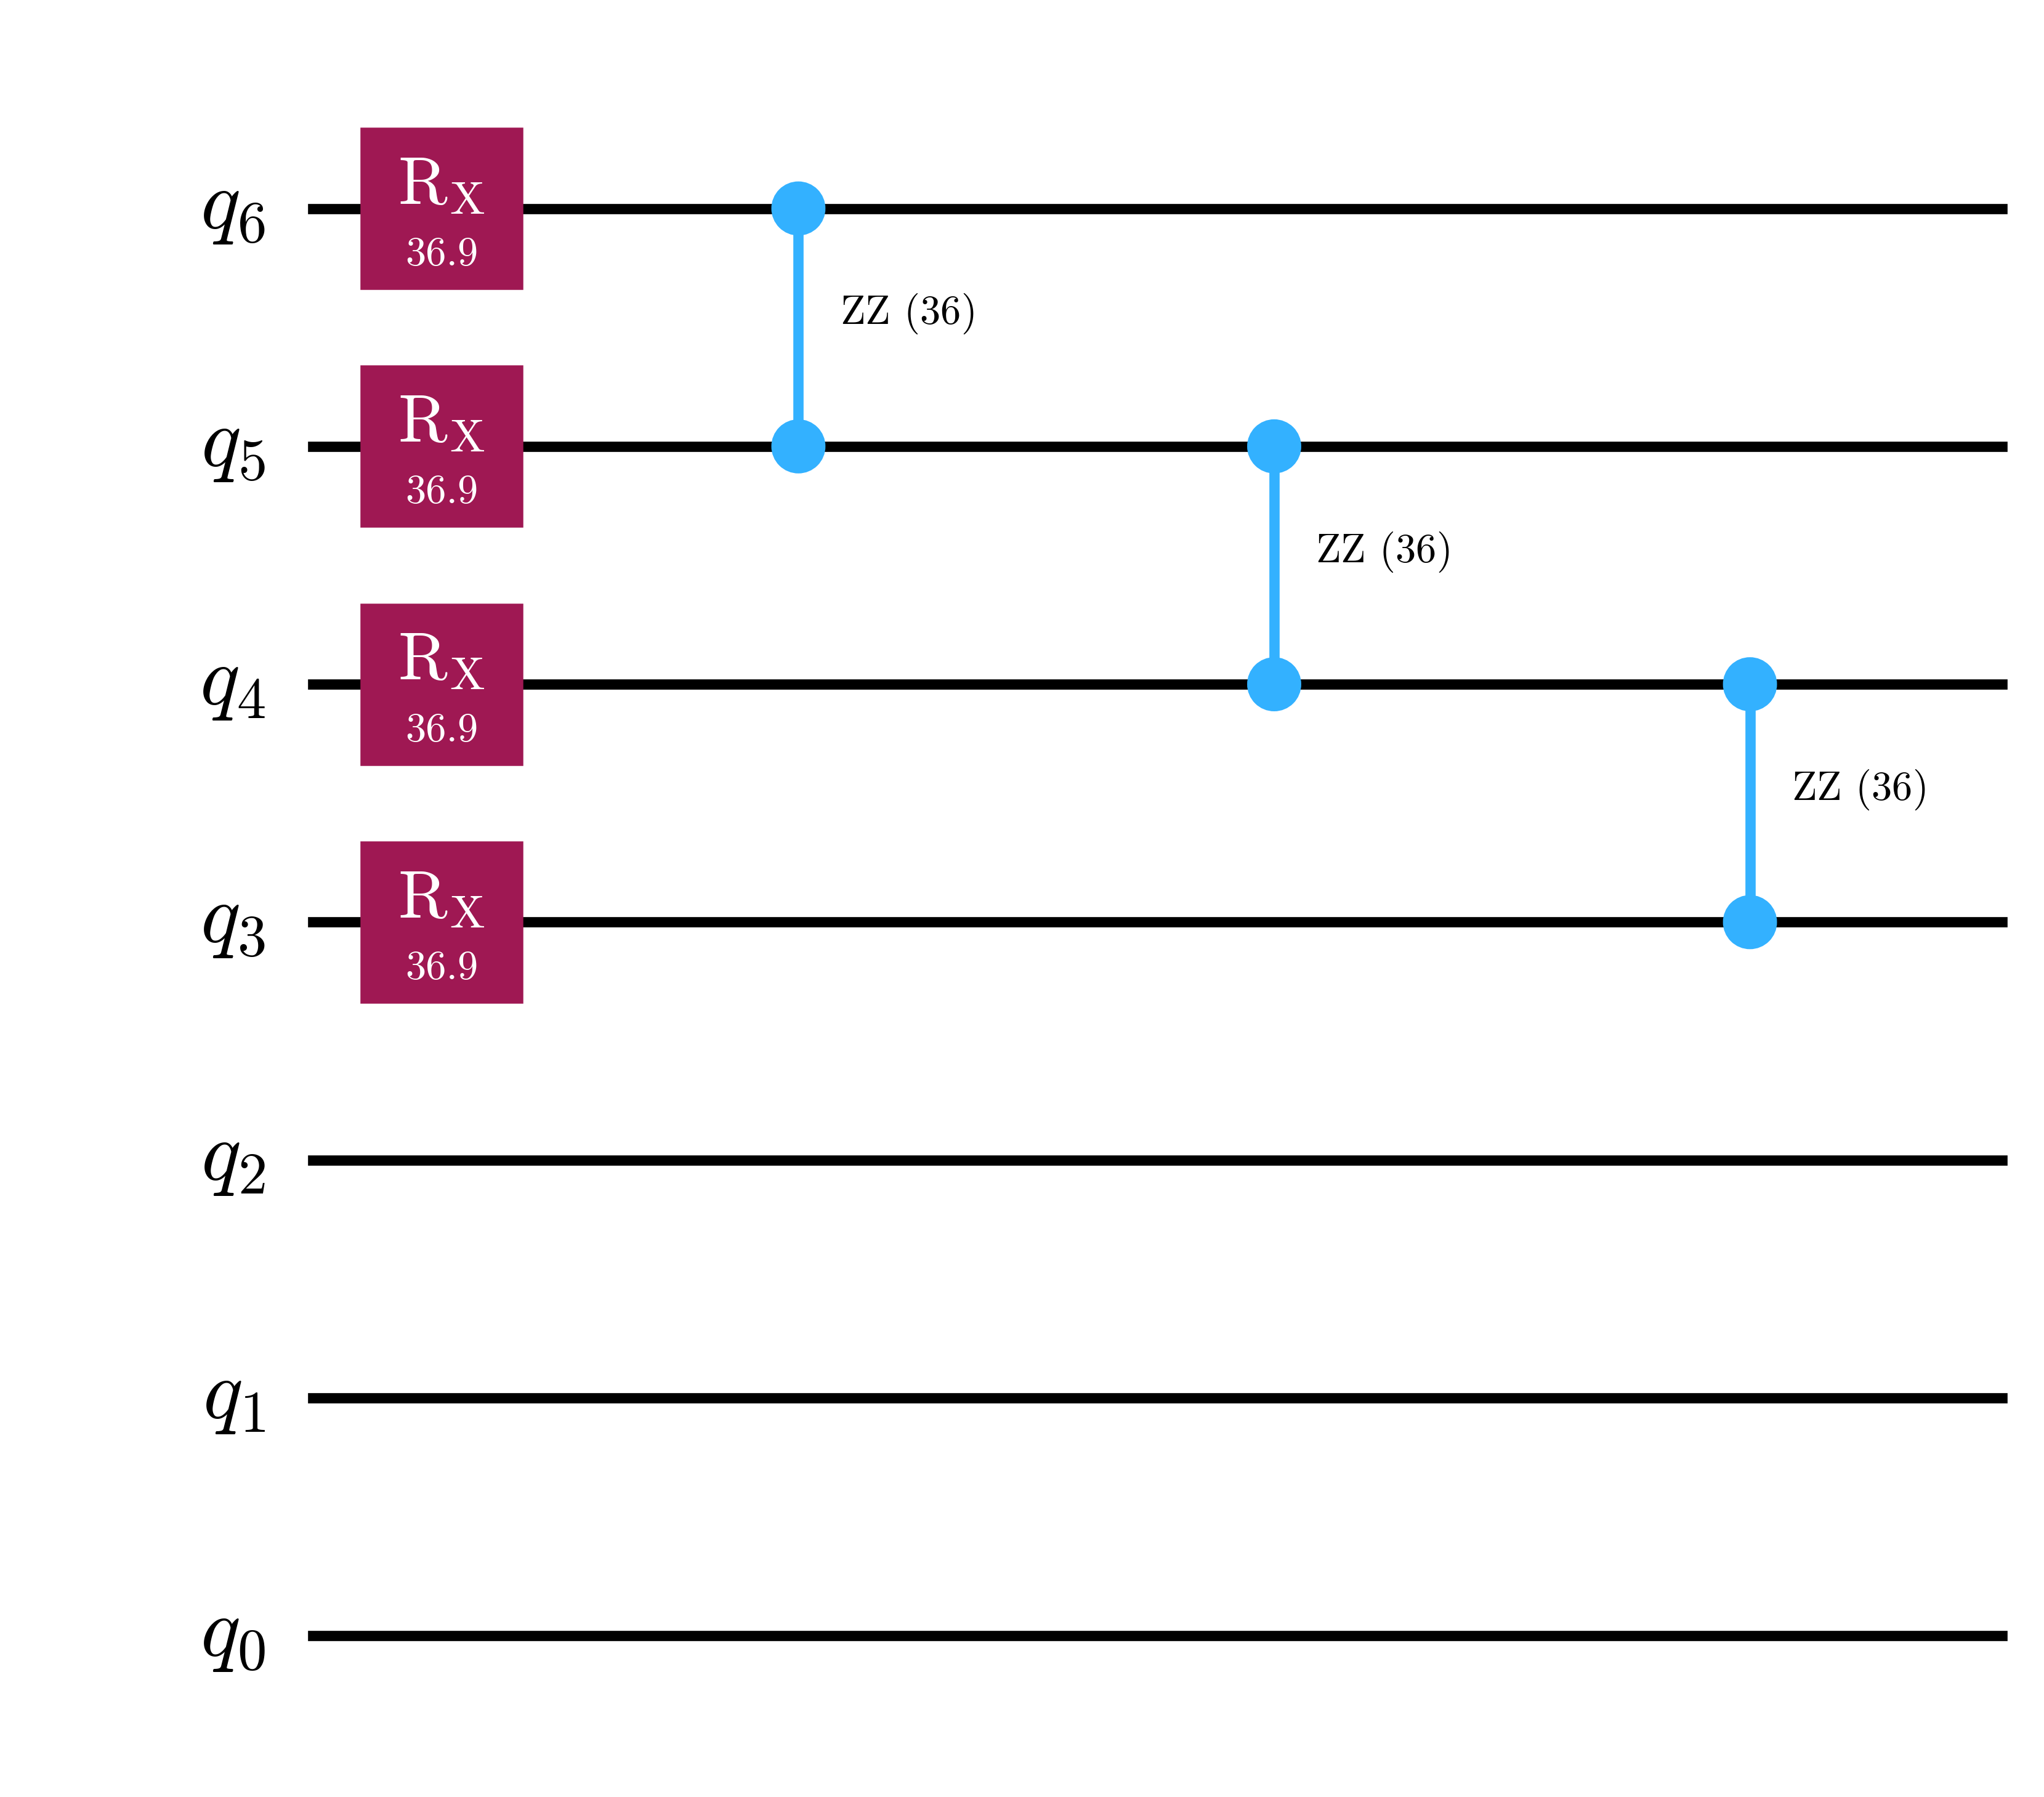

In [17]:
# Example SMILES string
smiles_string = "CCCC"

# Generate the Coulomb matrix without hydrogen atoms
coulomb_matrix_without_h = coulomb_matrix(smiles_string, add_hydrogens=False)
# print(coulomb_matrix_without_h)

# print("Coulomb matrix without hydrogen atoms:")
# print(coulomb_matrix_without_h)

circuit = matrix_to_circuit(coulomb_matrix_without_h, num_qubits = 7, entangling_layer='rzz', n_atom_to_qubit=1, interleaved='rzz', reverse_bits=True, n_layers=1)
statevector = np.array(Statevector(circuit))
circuit.draw(reverse_bits=True, output='mpl')
# print(statevector) # Print the statevector of the circuit

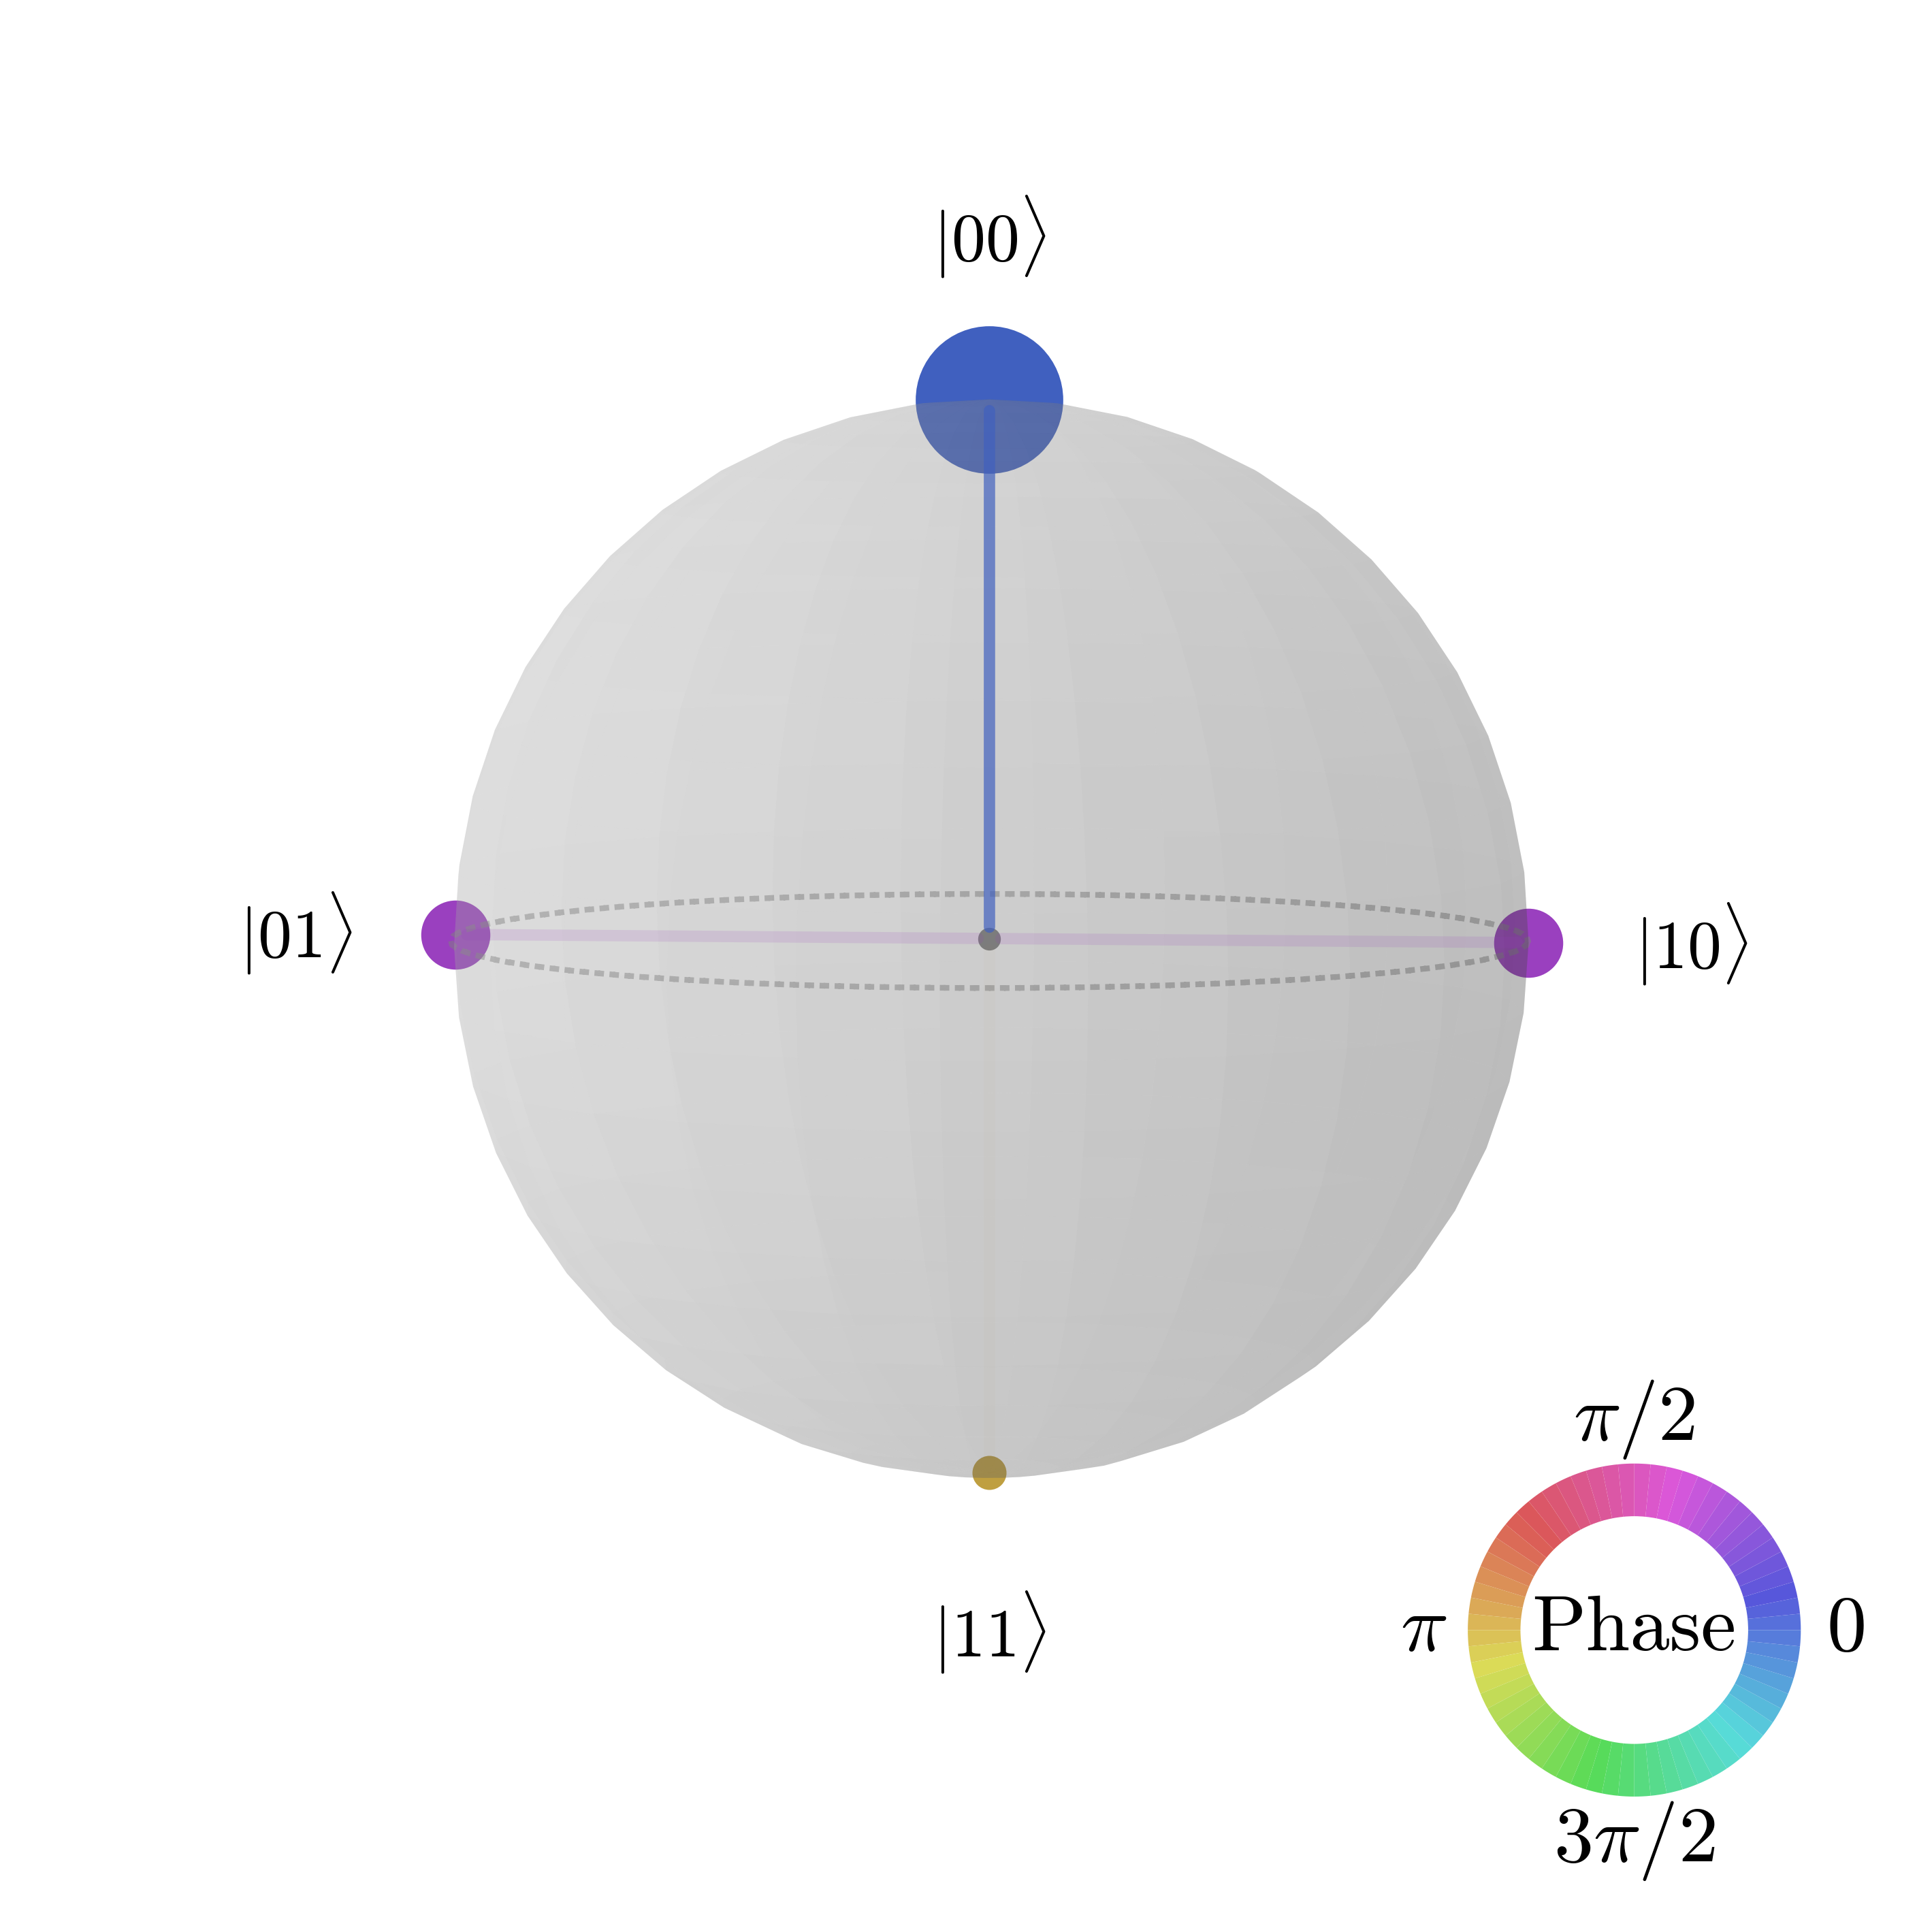

In [312]:
plot_state_qsphere(statevector, figsize=(6, 6))

In [46]:
df = pd.read_excel('/Users/choyboy/Documents/Python/QML/qm7.xlsx')
smiles_list = df['SMILES'].to_numpy()
num_rings = np.zeros(len(smiles_list), dtype=int)
for i in range(len(smiles_list)):
    molecule = smiles_list[i]
    count_1 = molecule.count('1')
    count_2 = molecule.count('2')
    if count_2 != 0:
        num_rings[i] = 2
    elif count_1 != 0:
        num_rings[i] = 1

print(num_rings)
df_rings = pd.DataFrame(num_rings)
df_rings.to_excel('/Users/choyboy/Documents/Python/QML/rings.xlsx', header=False, index=False)

[0 0 0 ... 0 1 2]


In [48]:
num_double = np.zeros(len(smiles_list), dtype=int)
num_triple = np.zeros(len(smiles_list), dtype=int)
for i in range(len(smiles_list)):
    molecule = smiles_list[i]
    count_1 = molecule.count('=')
    count_2 = molecule.count('#')
    num_double[i] = count_1
    num_triple[i] = count_2

df_double = pd.DataFrame(num_double)
df_triple = pd.DataFrame(num_triple)
df_double.to_excel('/Users/choyboy/Documents/Python/QML/double.xlsx', header=False, index=False)
df_triple.to_excel('/Users/choyboy/Documents/Python/QML/triple.xlsx', header=False, index=False)

In [4]:
# Define the SMILES strings for the alkanes
smiles_list = np.array(["CC","CCC", "CCCC", "CCCCC", "CCCCCC", "CCCCCCC", "CCCCCCCC", "CCCCCCCCC", "CCCCCCCCCC"])
# smiles_list = np.array(["C1CC1", "C1CCC1", "C1CCCC1", "C1CCCCC1", "C1CCCCCC1", "C1CCCCCCC1", "C1CCCCCCCC1", "C1CCCCCCCCC1"])
# smiles_list = np.array(["C=C/C=C/CC#N", "C=CC(=C)CC#N"])
# smiles_list = np.array(['c1ccccc1', 'c1c2ccccc2ccc1', 'c1ccc2cc3ccccc3cc2c1', 'c1c2cc3cc4ccccc4cc3cc2ccc1', 'c1c2cc3cc4cc5ccccc5cc4cc3cc2ccc1'])
# df = pd.read_excel('/Users/choyboy/Documents/Python/QML/qm7.xlsx')
# df_filter = df[df['num_total'] == 6]
# smiles_list = df_filter['SMILES'].to_numpy()


molecules = np.array([Chem.MolFromSmiles(smile) for smile in smiles_list])

# Generate fingerprints for each molecule
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=4, includeChirality=True, fpSize=2048)
fingerprints = ([fpgen.GetFingerprint(mol) for mol in molecules])

# Calculate Tanimoto similarity matrix
n = len(fingerprints)
tanimoto_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            tanimoto_matrix[i][j] = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
        else:
            tanimoto_matrix[i][j] = 1.0  # Similarity with itself is 1

# Display the Tanimoto similarity matrix

tanimoto_df = pd.DataFrame(tanimoto_matrix, index=smiles_list, columns=smiles_list)
tanimoto_df

,CC,CCC,CCCC,CCCCC,CCCCCC,CCCCCCC,CCCCCCCC,CCCCCCCCC,CCCCCCCCCC
CC,1.000000,0.500000,0.333333,0.250000,0.200000,0.166667,0.142857,0.142857,0.142857
CCC,0.500000,1.000000,0.666667,0.500000,0.400000,0.333333,0.285714,0.285714,0.285714
CCCC,0.333333,0.666667,1.000000,0.750000,0.600000,0.500000,0.428571,0.428571,0.428571
CCCCC,0.250000,0.500000,0.750000,1.000000,0.800000,0.666667,0.571429,0.571429,0.571429
CCCCCC,0.200000,0.400000,0.600000,0.800000,1.000000,0.833333,0.714286,0.714286,0.714286
CCCCCCC,0.166667,0.333333,0.500000,0.666667,0.833333,1.000000,0.857143,0.857143,0.857143
CCCCCCCC,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.000000,1.000000
CCCCCCCCC,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.000000,1.000000
CCCCCCCCCC,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.000000,1.000000


In [5]:
def quantum_overlap(num_qubits, smiles_list, add_hydrogens: bool = False, entangling_layer: str = 'rzz', initial_layer: str = 'rx', n_atom_to_qubit: int = 1, interleaved: str = None, n_layers: int = 1) -> np.array:
    n = len(smiles_list)
    overlap_matrix = np.ones((n, n))
    s = np.zeros([len(smiles_list), 2**num_qubits],dtype=complex)
    for i in range(len(smiles_list)):
        coulomb_matrix_without_h = coulomb_matrix(smiles_list[i], add_hydrogens=add_hydrogens)
        circuit = matrix_to_circuit(coulomb_matrix_without_h, num_qubits, initial_layer=initial_layer, n_layers=n_layers, reverse_bits=True, entangling_layer=entangling_layer, n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved)
        statevector = np.array(Statevector(circuit))
        s[i] = statevector
    for i in range(len(smiles_list)):
        for j in range(len(smiles_list)):
            if i < j:
                overlap = np.abs(np.vdot(s[i], s[j]))**2
                overlap_matrix[i][j] = overlap
            elif i > j:
                overlap_matrix[i][j] = overlap_matrix[j][i]
    return overlap_matrix

def save_to_excel(df, file_path, sheet_name):
    try:
        # If the file exists, append the DataFrame to the existing file
        with pd.ExcelWriter(file_path, mode='a', engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
    except FileNotFoundError:
        # If the file does not exist, create a new file and save the DataFrame
        df.to_excel(file_path, sheet_name=sheet_name, index=False, header=False)

In [151]:
df = pd.read_excel('/Users/choyboy/Documents/Python/QML/qm7_smiles_sorted.xlsx')
num_position = max(df['Position Group'].to_numpy())
position_array = np.linspace(1, num_position, num_position, dtype=int)
for i in range(num_position):
    num_pos = position_array[i]
    df_filter = df[df['Position Group'] == num_pos]
    smiles_list = df_filter['SMILES'].to_numpy()
    df_length = len(df_filter)
    molecules = np.array([Chem.MolFromSmiles(smile) for smile in smiles_list])
    fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
    fingerprints = ([fpgen.GetFingerprint(mol) for mol in molecules])
    n = len(fingerprints)
    tanimoto_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                tanimoto_matrix[i][j] = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
            else:
                tanimoto_matrix[i][j] = 1.0  # Similarity with itself is 1
    tanimoto_df = pd.DataFrame(tanimoto_matrix, index=smiles_list, columns=smiles_list)
    save_to_excel(tanimoto_df, 'qm7_tanimoto_series.xlsx', f'pos{num_pos}')
# tanimoto_df

In [14]:
overlap_df_x_xx = quantum_overlap(7, smiles_list, entangling_layer = 'rxx', n_atom_to_qubit=1, interleaved='ryy', n_layers=1)
overlap_df_x_yy = quantum_overlap(7, smiles_list, entangling_layer = 'ryy', n_atom_to_qubit=1, interleaved='ryy', n_layers=1)
overlap_df_x_zz = quantum_overlap(7, smiles_list, entangling_layer = 'rzz', n_atom_to_qubit=1, interleaved='ryy', n_layers=1)
overlap_df = pd.DataFrame(overlap_df_x_zz, index=smiles_list, columns=smiles_list)
overlap_df

,CC,CCC,CCCC,CCCCC,CCCCCC,CCCCCCC,CCCCCCCC,CCCCCCCCC,CCCCCCCCCC
CC,1.000000,0.572275,0.476909,0.397436,0.331205,0.276012,0.114713,0.007953,0.038603
CCC,0.572275,1.000000,0.572275,0.476909,0.397436,0.331205,0.137652,0.025324,0.021434
CCCC,0.476909,0.572275,1.000000,0.572275,0.476909,0.397436,0.165178,0.030388,0.003092
CCCCC,0.397436,0.476909,0.572275,1.000000,0.572275,0.476909,0.198208,0.036465,0.003710
CCCCCC,0.331205,0.397436,0.476909,0.572275,1.000000,0.572275,0.237843,0.043757,0.004452
CCCCCCC,0.276012,0.331205,0.397436,0.476909,0.572275,1.000000,0.386584,0.086009,0.015350
CCCCCCCC,0.114713,0.137652,0.165178,0.198208,0.237843,0.386584,1.000000,0.364002,0.145911
CCCCCCCCC,0.007953,0.025324,0.030388,0.036465,0.043757,0.086009,0.364002,1.000000,0.364002
CCCCCCCCCC,0.038603,0.021434,0.003092,0.003710,0.004452,0.015350,0.145911,0.364002,1.000000


In [90]:
# # Save x_xx, x_yy, and x_zz as different sheets in the same Excel file
# # save_to_excel(tanimoto_df, 'cycloalkane_series.xlsx', 'tanimoto')
# save_to_excel(x_xx, 'cycloalkane_series.xlsx', 'x_xx_l3_a2_cx')
# save_to_excel(x_yy, 'cycloalkane_series.xlsx', 'x_yy_l3_a2_cx')
# save_to_excel(x_zz, 'cycloalkane_series.xlsx', 'x_zz_l3_a2_cx')

In [162]:
df = pd.read_excel('/Users/choyboy/Documents/Python/QML/qm7_smiles_sorted.xlsx')
num_position = max(df['Position Group'].to_numpy())
position_array = np.linspace(1, num_position, num_position, dtype=int)

n_atom_to_qubit = 2
n_layers = 3
interleaved = 'cx'

for i in range(num_position):
    num_pos = position_array[i]
    df_filter = df[df['Position Group'] == num_pos]
    smiles_list = df_filter['SMILES'].to_numpy()
    overlap_df_x_xx = quantum_overlap(14, smiles_list, entangling_layer = 'rxx', n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved, n_layers=n_layers)
    overlap_df_x_yy = quantum_overlap(14, smiles_list, entangling_layer = 'ryy', n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved, n_layers=n_layers)
    overlap_df_x_zz = quantum_overlap(14, smiles_list, entangling_layer = 'rzz', n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved, n_layers=n_layers)
    x_xx = pd.DataFrame(overlap_df_x_xx)
    x_yy = pd.DataFrame(overlap_df_x_yy)
    x_zz = pd.DataFrame(overlap_df_x_zz)
    if interleaved == None:
        save_to_excel(x_xx, f'qm7_statevector_x_xx_l{n_layers}_a{n_atom_to_qubit}_series.xlsx', f'pos{num_pos}')
        save_to_excel(x_yy, f'qm7_statevector_x_yy_l{n_layers}_a{n_atom_to_qubit}_series.xlsx', f'pos{num_pos}')
        save_to_excel(x_zz, f'qm7_statevector_x_zz_l{n_layers}_a{n_atom_to_qubit}_series.xlsx', f'pos{num_pos}')
    else:
        save_to_excel(x_xx, f'qm7_statevector_x_xx_l{n_layers}_a{n_atom_to_qubit}_{interleaved}_series.xlsx', f'pos{num_pos}')
        save_to_excel(x_yy, f'qm7_statevector_x_yy_l{n_layers}_a{n_atom_to_qubit}_{interleaved}_series.xlsx', f'pos{num_pos}')
        save_to_excel(x_zz, f'qm7_statevector_x_zz_l{n_layers}_a{n_atom_to_qubit}_{interleaved}_series.xlsx', f'pos{num_pos}')
# tanimoto_df

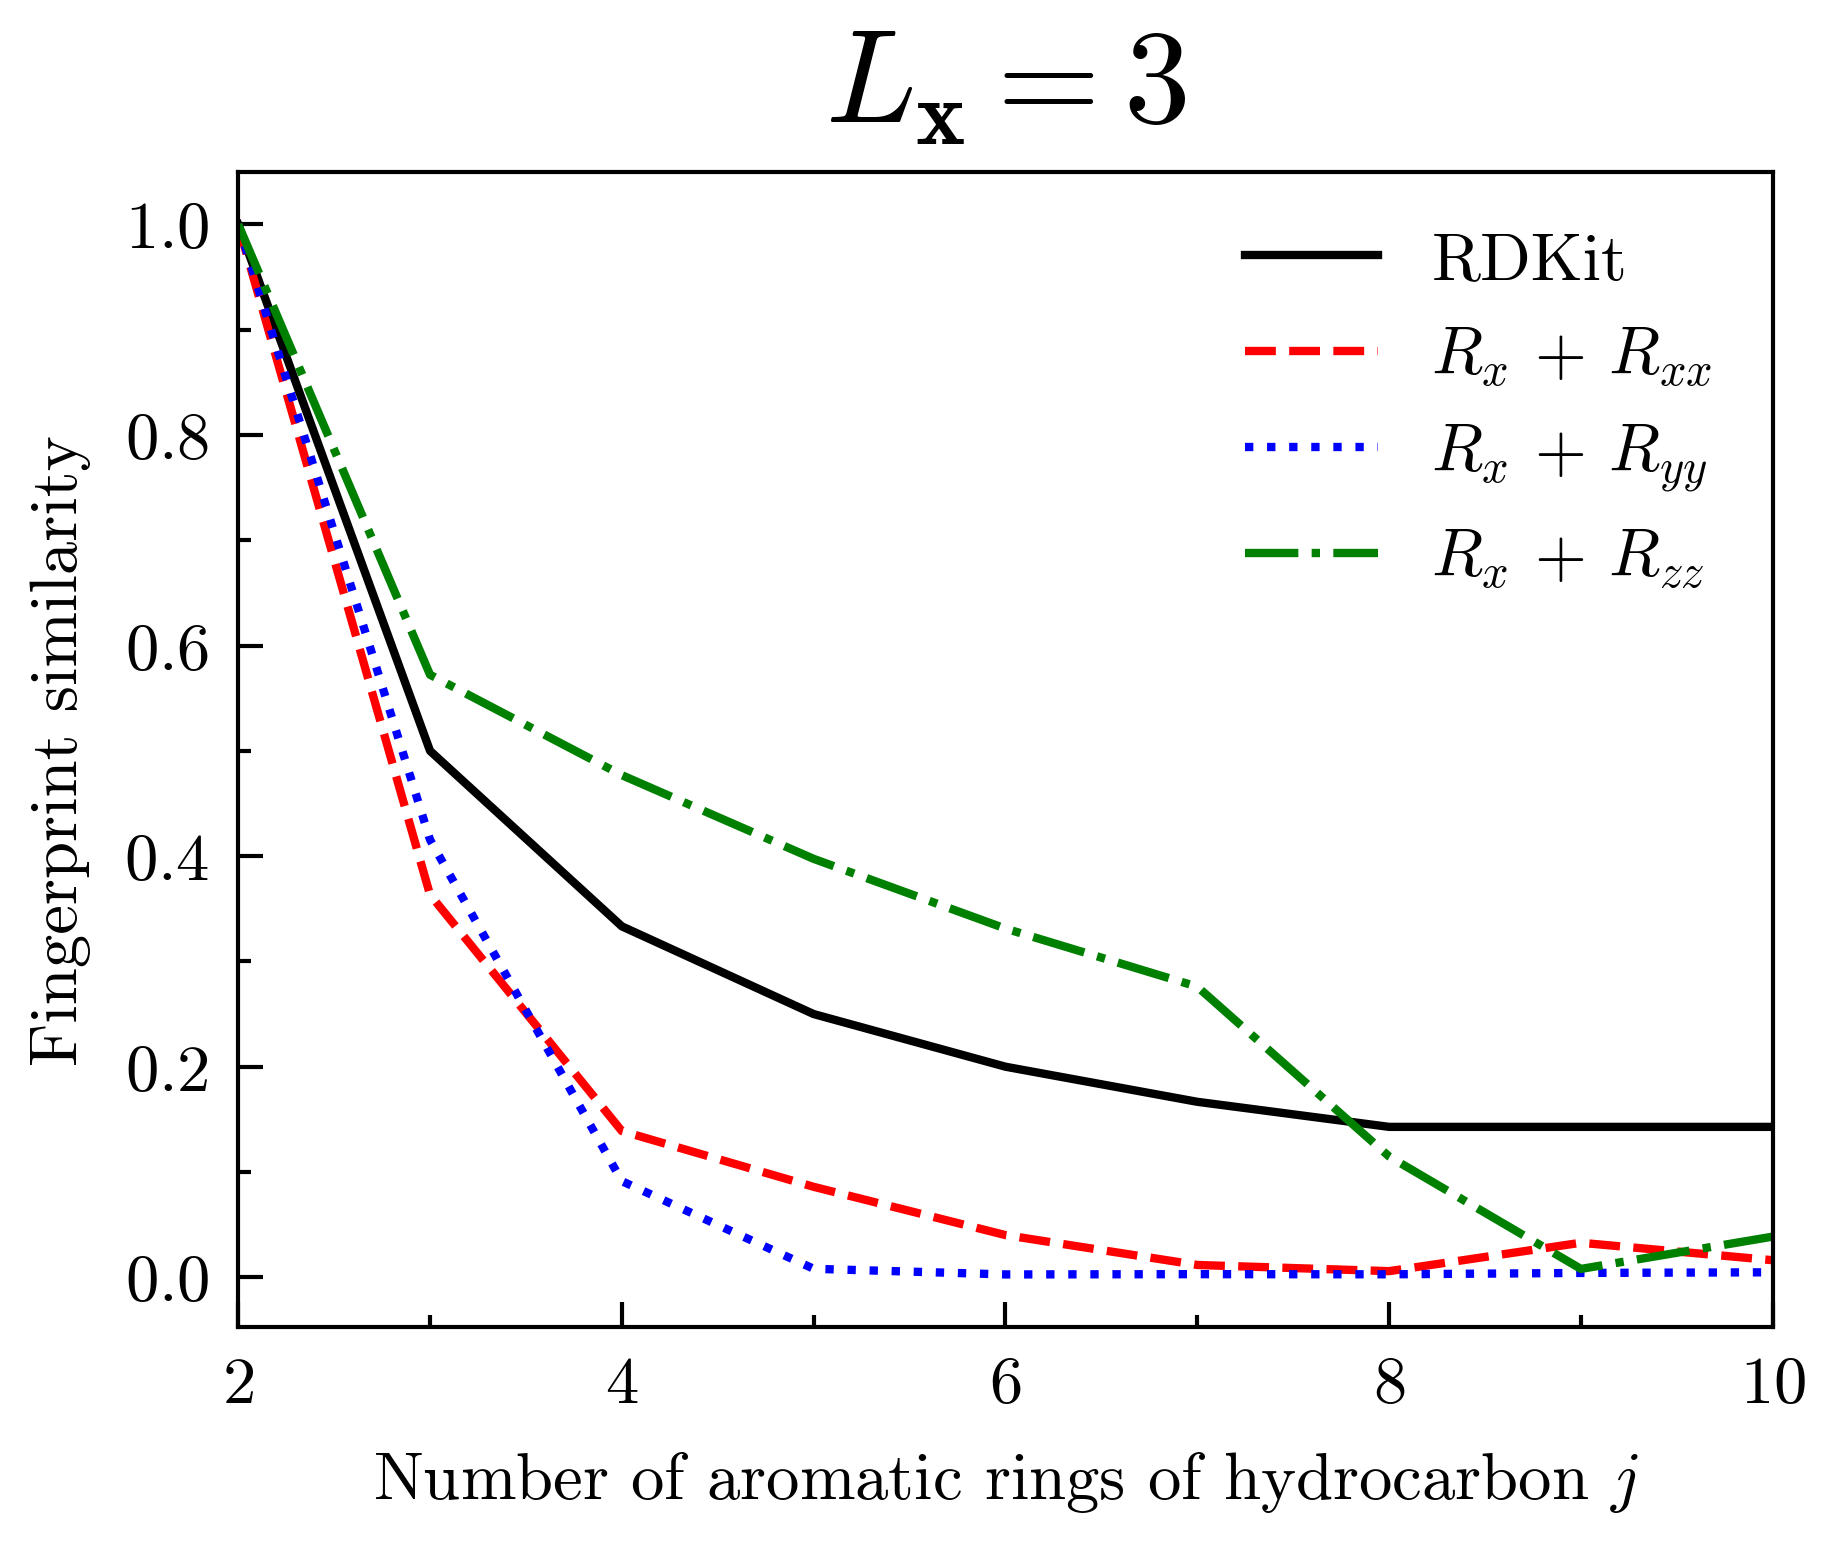

In [18]:
x_low = 2
x_high = 10
x = np.arange(x_low,x_high+1,1)
fig, ax = plt.subplots()
ax.plot(x, tanimoto_matrix[0, :])
ax.plot(x, overlap_df_x_xx[0, :])
ax.plot(x, overlap_df_x_yy[0, :])
ax.plot(x, overlap_df_x_zz[0, :])
ax.set_xticks(x, minor=True)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_title('$L_{\mathbf{x}}=3$', fontsize=16)
ax.set_xlabel('Number of aromatic rings of hydrocarbon $j$')
ax.set_ylabel('Fingerprint similarity')
ax.set_xlim(x_low, x_high)
ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
# ax.legend(['RDKit', '$R_x$ + CX + $R_{xx}$', '$R_x$ + CX + $R_{yy}$', '$R_x$ + CX + $R_{zz}$'])
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
# plt.savefig("figure_aromatic3.pdf", format="pdf", dpi=2000)



In [ ]:
x_low = 1
x_high = 3
x = np.arange(x_low,x_high+1,1)
fig, ax = plt.subplots()
ax.plot(x, tanimoto_matrix[0, :])
ax.plot(x, overlap_df_x_xx[0, :])
ax.plot(x, overlap_df_x_yy[0, :])
ax.plot(x, overlap_df_x_zz[0, :])
ax.set_xticks(x, minor=True)
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_title('Bond orders', fontsize=16)
ax.set_xlabel('Bond order of alkane $j$')
ax.set_ylabel('Fingerprint similarity')
ax.set_xlim(x_low, x_high)
# ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
# plt.savefig("figure_bond2.pdf", format="pdf", dpi=2000)


In [153]:
def quantum_sampler_overlap(num_shots, backend, smiles_list, add_hydrogens: bool = False, entangling_layer: str = 'rzz', initial_layer: str = 'rx', n_atom_to_qubit: int = 1, interleaved: str = None, n_layers: int = 1) -> np.array:
    n = len(smiles_list)
    overlap_matrix = np.zeros((n, n))
    for i in range(len(smiles_list)):
        for j in range(len(smiles_list)):
            if i <= j:
                matrix_A = coulomb_matrix(smiles_list[i], add_hydrogens=add_hydrogens)
                matrix_B = coulomb_matrix(smiles_list[j], add_hydrogens=add_hydrogens)
                max_size = max(matrix_A.shape[0], matrix_B.shape[0])
                total_qubits = max_size * n_atom_to_qubit
                circuit_A = matrix_to_circuit(matrix_A, total_qubits, initial_layer=initial_layer, n_layers=n_layers, reverse_bits=True, entangling_layer=entangling_layer, n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved)
                circuit_B = matrix_to_circuit(matrix_B, total_qubits, initial_layer=initial_layer, n_layers=n_layers, reverse_bits=True, entangling_layer=entangling_layer, n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved)
                compiled_circuit = UnitaryOverlap(circuit_A, circuit_B)
                compiled_circuit.measure_all()
                pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
                transpile_circuit = pm.run(compiled_circuit)
                sampler = Sampler(mode=backend, options={"default_shots": int(num_shots)})
                job = sampler.run([transpile_circuit])
                result = job.result()
                pub_result = result[0]
                counts = pub_result.data.meas.get_counts()
                prob_0 = counts['0'*total_qubits] / num_shots
                overlap_matrix[i][j] = prob_0
            else:
                overlap_matrix[i][j] = overlap_matrix[j][i]
    return overlap_matrix

In [177]:
num_shots = 1e5
backend = FakeTorino()
sampler_df_x_xx = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'rxx', n_atom_to_qubit=1, interleaved='cz', n_layers=3)
sampler_df_x_yy = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'ryy', n_atom_to_qubit=1, interleaved='cz', n_layers=3)
sampler_df_x_zz = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'rzz', n_atom_to_qubit=1, interleaved='cz', n_layers=3)
sampler_df = pd.DataFrame(sampler_df_x_xx, index=smiles_list, columns=smiles_list)
sampler_df

KeyboardInterrupt: 

In [114]:
sampler_x_xx = pd.DataFrame(sampler_df_x_xx)
sampler_x_yy = pd.DataFrame(sampler_df_x_yy)
sampler_x_zz = pd.DataFrame(sampler_df_x_zz)

# Save x_xx, x_yy, and x_zz as different sheets in the same Excel file
save_to_excel(sampler_x_xx, 'alkane_sampler_series.xlsx', 'x_xx_100k_l3')
save_to_excel(sampler_x_yy, 'alkane_sampler_series.xlsx', 'x_yy_100k_l3')
save_to_excel(sampler_x_zz, 'alkane_sampler_series.xlsx', 'x_zz_100k_l3')

In [ ]:
df = pd.read_excel('/Users/choyboy/Documents/Python/QML/qm7_smiles_sorted.xlsx')
num_position = max(df['Position Group'].to_numpy())
position_array = np.linspace(1, num_position, num_position, dtype=int)

n_atom_to_qubit = 1
n_layers = 1
interleaved = None
num_shots = 1e3
backend = FakeTorino()

for i in range(num_position):
    num_pos = position_array[i]
    df_filter = df[df['Position Group'] == num_pos]
    smiles_list = df_filter['SMILES'].to_numpy()
    sampler_df_x_xx = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'rxx', n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved, n_layers=n_layers)
    sampler_df_x_yy = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'ryy', n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved, n_layers=n_layers)
    sampler_df_x_zz = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'rzz', n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved, n_layers=n_layers)
    sampler_x_xx = pd.DataFrame(sampler_df_x_xx)
    sampler_x_yy = pd.DataFrame(sampler_df_x_yy)
    sampler_x_zz = pd.DataFrame(sampler_df_x_zz)
    if interleaved == None:
        save_to_excel(sampler_x_xx, f'qm7_sampler_x_xx_{int(num_shots/1e3)}k_l{n_layers}_a{n_atom_to_qubit}_series.xlsx', f'pos{num_pos}')
        save_to_excel(sampler_x_yy, f'qm7_sampler_x_yy_{int(num_shots/1e3)}k_l{n_layers}_a{n_atom_to_qubit}_series.xlsx', f'pos{num_pos}')
        save_to_excel(sampler_x_zz, f'qm7_sampler_x_zz_{int(num_shots/1e3)}k_l{n_layers}_a{n_atom_to_qubit}_series.xlsx', f'pos{num_pos}')
    else:
        save_to_excel(sampler_x_xx, f'qm7_sampler_x_xx_{int(num_shots/1e3)}k_l{n_layers}_a{n_atom_to_qubit}_{interleaved}_series.xlsx', f'pos{num_pos}')
        save_to_excel(sampler_x_yy, f'qm7_sampler_x_yy_{int(num_shots/1e3)}k_l{n_layers}_a{n_atom_to_qubit}_{interleaved}_series.xlsx', f'pos{num_pos}')
        save_to_excel(sampler_x_zz, f'qm7_sampler_x_zz_{int(num_shots/1e3)}k_l{n_layers}_a{n_atom_to_qubit}_{interleaved}_series.xlsx', f'pos{num_pos}')

In [ ]:
x_low = 2
x_high = 10
x = np.arange(x_low,x_high+1,1)
fig, ax = plt.subplots()
ax.plot(x, tanimoto_matrix[0, :])
ax.plot(x, sampler_df_x_xx[0, :])
ax.plot(x, sampler_df_x_yy[0, :])
ax.plot(x, sampler_df_x_zz[0, :])
ax.set_xticks(x, minor=True)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_title('$L_{\mathbf{x}}=3$', fontsize=16)
ax.set_xlabel('Number of carbon atoms of alkane $j$')
ax.set_ylabel('Fingerprint similarity')
ax.set_xlim(x_low, x_high)
# ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
plt.savefig("figure_alkane_sampler_100k_3.pdf", format="pdf", dpi=2000)


In [75]:
def quantum_estimator_overlap(num_shots, backend, smiles_list, add_hydrogens: bool = False, entangling_layer: str = 'rzz', initial_layer: str = 'rx', n_atom_to_qubit: int = 1, interleaved: str = 'None', n_layers: int = 1) -> np.array:
    n = len(smiles_list)
    overlap_matrix = np.zeros((n, n))
    for i in range(len(smiles_list)):
        for j in range(len(smiles_list)):
            if i <= j:
                matrix_A = coulomb_matrix(smiles_list[i], add_hydrogens=add_hydrogens)
                matrix_B = coulomb_matrix(smiles_list[j], add_hydrogens=add_hydrogens)
                max_size = max(matrix_A.shape[0], matrix_B.shape[0])
                total_qubits = max_size * n_atom_to_qubit
                pauli_op = SparsePauliOp('Z'*total_qubits)
                circuit_A = matrix_to_circuit(matrix_A, total_qubits, initial_layer=initial_layer, n_layers=n_layers, reverse_bits=True, entangling_layer=entangling_layer, n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved)
                circuit_B = matrix_to_circuit(matrix_B, total_qubits, initial_layer=initial_layer, n_layers=n_layers, reverse_bits=True, entangling_layer=entangling_layer, n_atom_to_qubit=n_atom_to_qubit, interleaved=interleaved)
                compiled_circuit = UnitaryOverlap(circuit_A, circuit_B)
                transpile_circuit = transpile(compiled_circuit, backend)
                transpile_op = pauli_op.apply_layout(transpile_circuit.layout)
                estimator = Estimator(backend)
                estimator.options.default_shots = num_shots
                pub = (transpile_circuit, transpile_op)
                job = estimator.run([pub])
                result = job.result()
                data = result[0].data
                ex = data.evs
                overlap_matrix[i][j] = ex
            else:
                overlap_matrix[i][j] = overlap_matrix[j][i]
    return overlap_matrix